In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [35]:
import glob
%matplotlib inline
images = glob.glob('./camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [36]:
def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = cv2.undistort(img, mtx,  dist, None, mtx)
    return undist

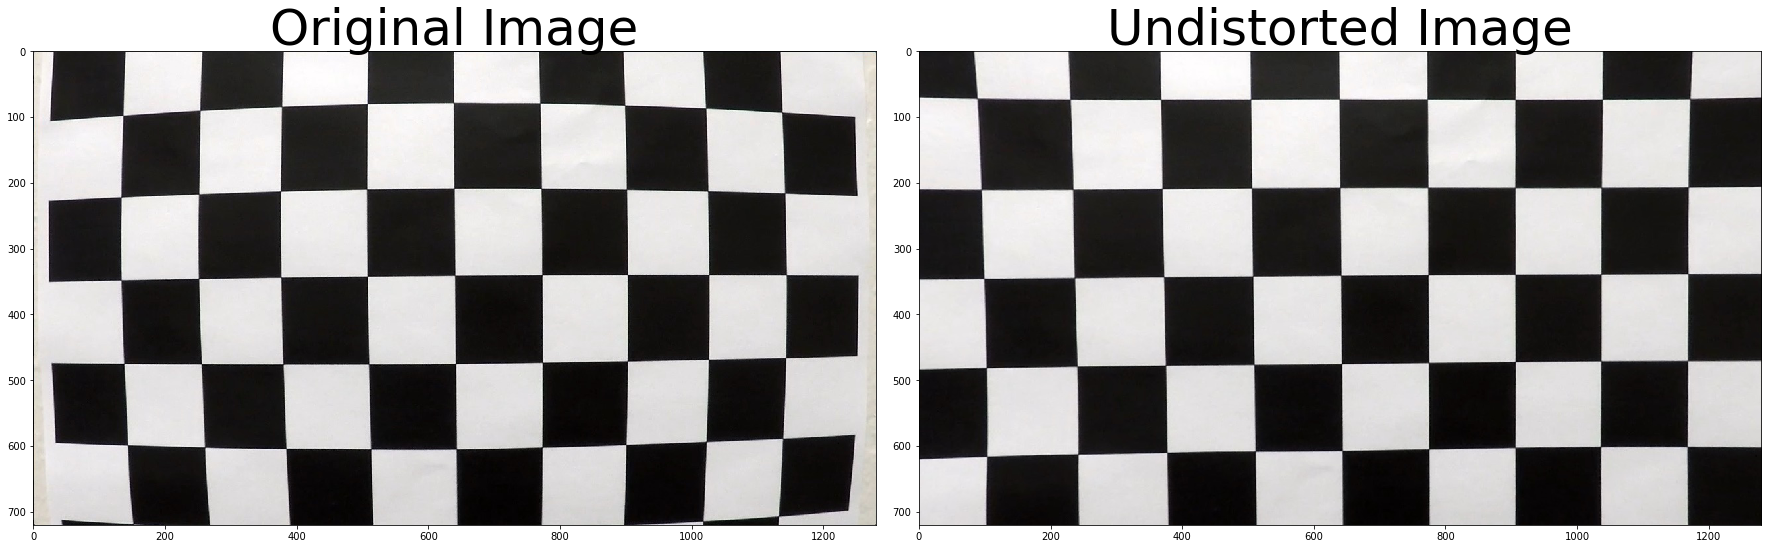

In [37]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, mtx, dist)
# plt.imshow(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [38]:
def edges(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

#     # Plotting thresholded images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.set_title('Stacked thresholds')
#     ax1.imshow(color_binary)

#     ax2.set_title('Combined S channel and gradient thresholds')
#     ax2.imshow(combined_binary, cmap='gray')
    return combined_binary

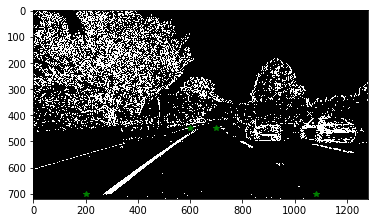

In [273]:

img = mpimg.imread('./test_images/test6.jpg')
undistorted = cal_undistort(img, mtx, dist)
combined_binary = edges(undistorted)
plt.imshow(combined_binary, cmap = 'gray')
src=np.float32([(600,450),(220,700),(1080,700),(700,450)])
dst=np.float32([(200,0),(200,700),(1000,700),(1000,0)]) 
plt.plot(src_pts[:,0], src_pts[:,1] , 'g*')

In [274]:
def warp(img, inverse = False):
    matrix = cv2.getPerspectiveTransform(src,dst)
    inv_matrix = cv2.getPerspectiveTransform(dst,src)
    if inverse == False:
        warped_img=cv2.warpPerspective(img,matrix,(img.shape[1],img.shape[0]),flags=cv2.INTER_CUBIC)
    if inverse == True:
        warped_img=cv2.warpPerspective(img,inv_matrix,(img.shape[1],img.shape[0]),flags=cv2.INTER_CUBIC)
    return warped_img

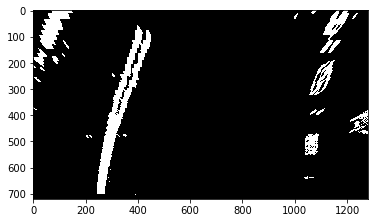

In [275]:
warped_img = warp(combined_binary)
plt.imshow(warped_img, cmap = 'gray')

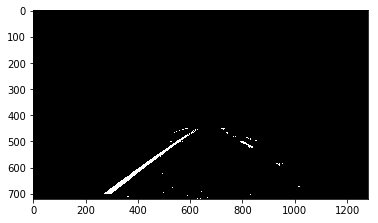

In [276]:
unwarped_img = warp(warped_img, inverse = True)
plt.imshow(unwarped_img, cmap = 'gray')

In [277]:
def fit_lines(binary_warped, visualize = False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize == True:
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return left_fit, right_fit

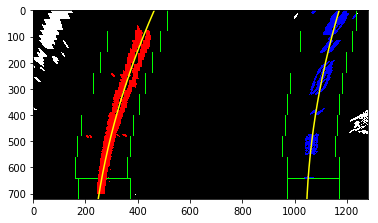

In [278]:
left_fit, right_fit = fit_lines(warped_img, visualize = True)


In [279]:
def fit_subsequent_frames(binary_warped, left_fit, right_fit, visualize = False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if visualize == True:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit, right_fit

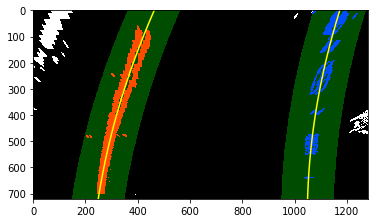

In [280]:
left_fit , right_fit = fit_subsequent_frames(warped_img, left_fit, right_fit, visualize = True)

In [287]:
def get_road(img,left_fit,right_fit,mtx):
    #converting pixel space to world space and obtaining the entire road
    y_factor=30/720
    x_factor=3.7/700
#     y_factor=1
#     x_factor=1
    plot=np.linspace(0,img.shape[0]-1,img.shape[0])
    y_eval=np.max(plot)
    leftx=left_fit[0]*plot**2 + left_fit[1]*plot + left_fit[2]
    rightx=right_fit[0]*plot**2 + right_fit[1]*plot + right_fit[2]
    left_fit_real=np.polyfit(plot*y_factor,leftx*x_factor,2)  # indicates real world polynomial
    right_fit_real=np.polyfit(plot*y_factor,rightx*x_factor,2)
    left_curverad = format(((1 + (2*left_fit_real[0]*y_eval*y_factor + left_fit_real[1])**2)**1.5) / np.absolute(2*left_fit_real[0]),'.2f')
    right_curverad =format(((1 + (2*right_fit_real[0]*y_eval*y_factor + right_fit_real[1])**2)**1.5) / np.absolute(2*right_fit_real[0]),'.2f')
    left_point=left_fit_real[0]*(y_eval*y_factor)**2 +left_fit_real[1]*(y_eval*y_factor) + left_fit_real[2]
    right_point=right_fit_real[0]*(y_eval*y_factor)**2 + right_fit_real[1]*(y_eval*y_factor) + right_fit_real[2]   
    mid_point=(left_point+right_point)/2
    difference=format(x_factor*img.shape[1]/2-mid_point,'.2f') # indicates the offset from the center. negative means the car is tending towards the left annd vice versa
    left= np.array([np.transpose(np.vstack([leftx, plot]))])
    right= np.array([np.flipud(np.transpose(np.vstack([rightx, plot])))])
    road=np.hstack((left,right))
    mask=np.zeros_like(img)
    cv2.fillPoly(mask,np.int32(road),[0,255,0])
    mask=cv2.warpPerspective(mask,mtx,(img.shape[1],img.shape[0]))
    out=cv2.addWeighted(img,.8,mask,.5,0)
    cv2.putText(out,"Left Curvature = "+left_curverad + 'm',(50,50),cv2.FONT_HERSHEY_PLAIN,3,[255,255,2],thickness=2)
    cv2.putText(out,"Right Curvature = "+right_curverad+ 'm',(50,85),cv2.FONT_HERSHEY_PLAIN,3,[255,255,2],thickness=2)
    cv2.putText(out,"Distance from Center = "+difference+ 'm',(50,115),cv2.FONT_HERSHEY_PLAIN,3,[255,255,2],thickness=2)
    return out


In [288]:
matrix = cv2.getPerspectiveTransform(src,dst)
inv_matrix = cv2.getPerspectiveTransform(dst,src)
final = get_road(undistorted, left_fit, right_fit, inv_matrix)

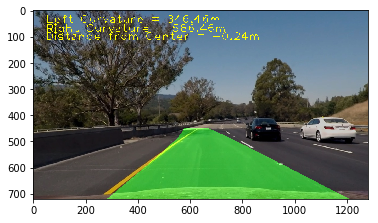

In [289]:
plt.imshow(final)

In [291]:
from moviepy.editor import VideoFileClip
input_v = VideoFileClip("project_video.mp4")
output_video_file = 'final_video.mp4'
frame = input_v.get_frame(0)
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
# writer=cv2.VideoWriter('output.avi',fourcc,25,(frame.shape[1],frame.shape[0]))
#undistort, find edges,warp and get initial line position
img_undistorted=cv2.undistort(frame,mtx,dist,None,None)
edge=edges(img_undistorted)
warped=warp(edge)
left_fit,right_fit=fit_lines(warped)
# vid=cv2.VideoCapture("./project_video.mp4")
# for img in input_v.iter_frames():
def pipeline(img):
    global left_fit
    global right_fit
    img_undistorted=cv2.undistort(img,mtx,dist,None,None)
#     warped_original=get_birds_eye_view(img_undistorted,matrix)
    edge=edges(img_undistorted)
    warped=warp(edge)
    left_fit,right_fit=fit_subsequent_frames(warped,left_fit,right_fit)
#     pl_img=np.zeros_like(img)
    img=get_road(img_undistorted,left_fit,right_fit,inv_matrix)   
#     cv2.namedWindow("img",0)
#     cv2.imshow('img',img)
#     cv2.waitKey(1)
#     writer.write(img)
    return img
input_v = VideoFileClip("project_video.mp4")
output_video = input_v.fl_image(pipeline)
output_video.write_videofile(output_video_file, audio=False)
    
# while(True):
#     ret,img=vid.read()
#     if(not ret):
#         print("No Frame")
#         break
#     img_undistorted=cv2.undistort(img,mtx,dist,None,None)
# #     warped_original=get_birds_eye_view(img_undistorted,matrix)
#     edge=edges(img_undistorted)
#     warped=warp(edge)
#     left_fit,right_fit=fit_subsequent_frames(warped,left_fit,right_fit)
# #     pl_img=np.zeros_like(img)
#     img=get_road(img_undistorted,left_fit,right_fit,inv_matrix)   
#     cv2.namedWindow("img",0)
#     cv2.imshow('img',img)
#     cv2.waitKey(20)
#     writer.write(img)

[MoviePy] >>>> Building video final_video.mp4
[MoviePy] Writing video final_video.mp4


100%|█████████▉| 1260/1261 [02:05<00:00, 10.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_video.mp4 



In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid=cv2.VideoCapture("project_video.mp4")
# if(not vid.isOpened()):
#     print("Video Not opened ")
#     sys.exit(-1)
ret, frame = vid.read()
writer=cv2.VideoWriter('output.avi',fourcc,25,(frame.shape[1],frame.shape[0]))
#undistort, find edges,warp and get initial line position
img_undistorted=cv2.undistort(frame,mtx,dist,None,None)
edge=edges(img_undistorted)
warped=warp(edge)
left_fit,right_fit=fit_lines(warped)
while(True):
    ret,img=vid.read()
    if(not ret):
        print("No Frame")
        break
    img_undistorted=cv2.undistort(img,mtx,dist,None,None)
#     warped_original=get_birds_eye_view(img_undistorted,matrix)
    edge=edges(img_undistorted)
    warped=warp(edge)
    left_fit,right_fit=fit_subsequent_frames(warped,left_fit,right_fit)
#     pl_img=np.zeros_like(img)
    img=get_road(img_undistorted,left_fit,right_fit,inv_matrix)   
    cv2.namedWindow("img",0)
    cv2.imshow('img',img)
    cv2.waitKey(20)
    writer.write(img)